<img align="center" style='max-width: 1000px' src="images/banner.png">

<img align="left" style='max-width: 150px; height: auto' src="images/hsg_logo.png">

# Lab 02 - "Continual Learning"


## Outline

### 1. Why Continual Learning?
- What is continual learning about in practice?
- How does forgetting happen in neural networks?

### 2. Avalanche
- Main Avalanche components
- Implementing continual learning strategies in Avalanche

## Objective

After learning the concepts in this lab, you should be able to:

- Identify and formulate a continual learning problem
- Create a continual data stream from a static dataset
- Implement new algorithms for continual learning using Avalanche



## Packages

In [1]:
# !pip install avalanche-lib

In [3]:
import torch
import torch.nn as nn

import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")


# <font color='red'>1. Continual Learning</font>


What do we exactly want to do in practice? 

Let's start with a demo:


https://www.youtube.com/watch?v=Bs3tSjwbHa4

Continual learning is useful for the cases where we have consistent shift in the data.

#### Distribution Changes
Data distributions can change over time -> predictions can become less accurate
<img align="center" width="700" src="images/segmentation.png">

Source: https://arxiv.org/abs/2011.11390


#### Training Costs and Sustainability

- Training from scratch for every new batch of data is not sustainable for large models, and it can be very expensive.
- Training a single GPT-3 model is ~4.6 Million dollars!
- Maintanance costs can be very expensive.

#### Theoretical and Biological Reasons
Neuroscience:

<img align="center" width="700" src="images/biological_mechanisms.png">

Reference paper: https://www.socsci.uci.edu/~jkrichma/Kudithipudi-BiologicalUnderpinnings-NatMachIntel-2022.pdf

Theory:
- Can we achieve a better solution via continual learning?
- Recent works have shown that join training is a "soft" upper-bound for continual learning!

#### One Big Challenge
Catastrophic forgetting:

- There is no guarantee that when a model is trained on new data it would preserve its performance on older tasks.



### 1.2 Catastrophic Forgetting

Toy example: we want to classify data samples from a 2D blobs dataset.

In [4]:
import sklearn.datasets

In [5]:
def get_blobs_dataset(classes):
    """ Creates and returns blobs datataset for a given list of classes."""
    
    # Generate Blobs
    X, Y = sklearn.datasets.make_blobs(n_samples=500, centers=6, n_features=2,
                                       random_state=7, cluster_std=1.8)
    
    # Convert numpy arrays to PyTorch tensors.
    X = torch.FloatTensor(X)
    Y = torch.LongTensor(Y)
    
    # Placeholder for list of tensors from the given list of classes
    X_ = []
    Y_ = []
    
    # Only add the tensors in the class list
    for c in classes:
        X_.append(X[torch.where(Y==c)])
        Y_.append(Y[torch.where(Y==c)])
    
    # Concat the class tensor lists and return them
    X = torch.cat(X_, dim=0)
    Y = torch.cat(Y_, dim=0)
    
    return X, Y

We create a dataset of blobs, and split it into two separate tasks:

Text(0.5, 1.0, 'Task 2')

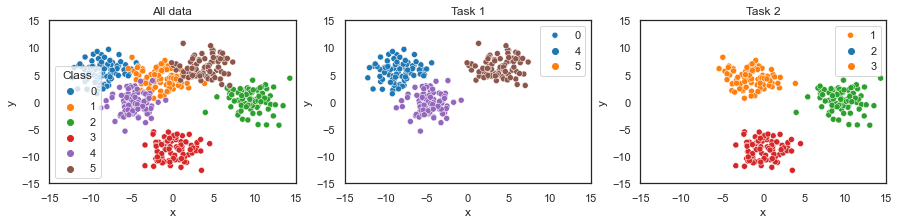

In [6]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3)

all_classes = [0, 1, 2, 3, 4, 5]
task1_classes = [0, 4, 5]
task2_classes = [1, 2, 3]

# Plot data from all classes
X, Y = get_blobs_dataset(classes=all_classes)
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[0], hue_order=all_classes, palette="tab10")
ax[0].set_xlim([-15, 15])
ax[0].set_ylim([-15, 15])
ax[0].set_title("All data")

# Plot Task 1 data
X, Y = get_blobs_dataset(classes=task1_classes)
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[1], hue_order=all_classes, palette="tab10")
ax[1].legend(task1_classes)
ax[1].set_xlim([-15, 15])
ax[1].set_ylim([-15, 15])
ax[1].set_title("Task 1")

# Plot Task 2 data
X, Y = get_blobs_dataset(classes=task2_classes)
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[2], hue_order=all_classes, palette="tab10")
ax[2].legend(task2_classes)
ax[2].set_xlim([-15, 15])
ax[2].set_ylim([-15, 15])
ax[2].set_title("Task 2")


We want to train a model in two different ways:

- Using all data together
- First train on task 1, and then train on task 2

In [7]:
class MLP(nn.Module):
    """ Implementation of a simple MLP with two hidden layers. """
    def __init__(self, n_classes=2):
        super().__init__()
        self.linear1 = nn.Linear(2, 10)
        self.linear2 = nn.Linear(10, n_classes)
        self.nonlin = nn.Tanh()

    def forward(self, x):
        x = self.nonlin(self.linear1(x))
        x = self.linear2(x)
        return x


We train the model with the standard SGD optimizer and cross entropy criterion.

In [8]:
def train_model(classes=[0, 1, 2], n_epochs=100, model=None):
    """ Trains a model for a given set of classes.
    
        classes: list of classes to use for training.
        n_epochs: number of training epochs
        model: the model to use for training.
    """
    # If no model is given, define a model with random intialization
    if model == None:
        model = MLP(n_classes=6)
    
    # Initialize criterion, optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    
    # Initialize datasets with the given set of classes
    X, Y = get_blobs_dataset(classes)

    # Progress bar
    progress = tqdm.tqdm(list(range(n_epochs)))
    
    # Training epochs
    for epoch in progress:
        model.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()
        
        progress.update()
    
    return model

And finally, after training the model, we plot the decision boundary of the model.

In [9]:
def plot_decision_boundary(model, classes, title=""):
    """ Plot model decision bounday."""
    
    # Creat meshgrid for a box range of [-15, 15] for x and y
    x_ = torch.linspace(-15, 15, 2000)
    y_ = torch.linspace(-15, 15, 2000)
    xx, yy = torch.meshgrid(x_, y_)
    
    # Compute model predicition for the meshgrid
    xx_model = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)
    zz = torch.argmax(model(xx_model), dim=1).reshape(2000, 2000)
    
    # Get data
    X, Y = get_blobs_dataset(classes=classes)
    
    data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
    # Set figure size
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Decision boundary (contour plot)
    ax.contourf(xx, yy, zz, cmap=plt.cm.RdYlBu, alpha=0.5)
    
    
    # Plot samples from the given list of classes
    sns.scatterplot(data=data, x="x", y="y", hue="Class",  hue_order=all_classes,  ax=ax, palette="tab10", )
#     ax.legend(classes)
    
    # Set tile
    ax.set_title(title)


#### Joint Training

In the first scenario, we use the whole dataset to train a model.

100%|██████████| 200/200 [00:00<00:00, 2160.41it/s]


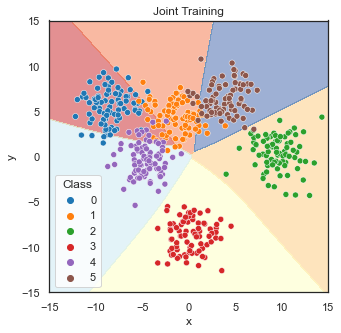

In [11]:
model = train_model(classes=[0, 1, 2, 3, 4, 5], n_epochs=200)
plot_decision_boundary(model, classes=[0, 1, 2, 3, 4, 5], title="Joint Training")

#### Incremental Training

In the second scenario, we split the classes as below to train the model in two episodes:

Train the model on task 1:

100%|██████████| 300/300 [00:00<00:00, 2268.78it/s]


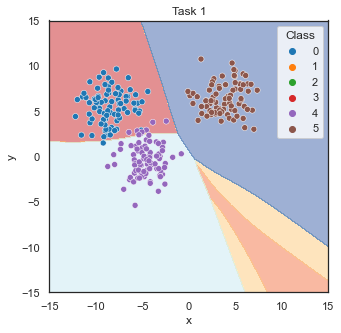

In [12]:
# Train model from a random initilization
model_task1 = train_model(classes=task1_classes, n_epochs=300)

# Plot decision boundary for task 1
plot_decision_boundary(model_task1, classes=task1_classes, title="Task 1")

Train the model on task 2:

100%|██████████| 300/300 [00:00<00:00, 1760.13it/s]


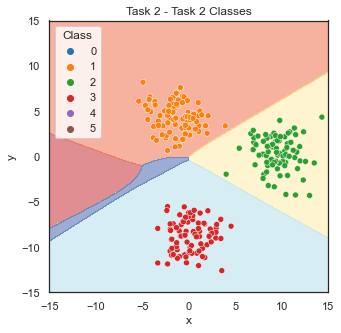

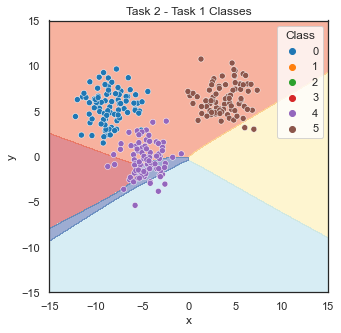

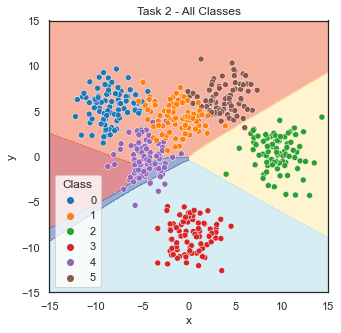

In [14]:
# Train model using previoudly train model on task 1
model_task2 = train_model(classes=task2_classes, model=model_task1, n_epochs=300)

# Plot decision boundary for task 2
plot_decision_boundary(model_task2, classes=task2_classes, title="Task 2 - Task 2 Classes")

# Plot decision boundary for task 2
plot_decision_boundary(model_task2, classes=task1_classes, title="Task 2 - Task 1 Classes")

# Plot decision boundary for task 2
plot_decision_boundary(model_task2, classes=task1_classes+task2_classes, title="Task 2 - All Classes")

#### Other CL Objectives
Continual learning is not just about catastrophic forgetting!

- Knoweldge transfer
- Forward Transfer (Zero-Shot Learning)
- Backward Transfer

<img align="center" width="700" src="images/cl_objectives.png">

Figure credit: https://www.socsci.uci.edu/~jkrichma/Kudithipudi-BiologicalUnderpinnings-NatMachIntel-2022.pdf


#### Example: Auto-Adaptive Machine Learning Architecture

In reality, a machine learning system can be composed of many components:

<img align="center" width="500" src="images/amazon_cl.png">

Reference paper: https://arxiv.org/abs/1903.05202

# <font color='red'>2. Avalanche</font>


- Avalanche is an end-to-end library for continual learning.

- It is one of the open source products of Continual AI: https://www.continualai.org/


#### Library Components
The library consists of different components that can be used separately:

<img align="center" width="400" src="images/avalanche.png">

Link: https://avalanche.continualai.org/


#### Data Streams in Avalanche
Data streams consist of sequence of experiences where each experience contains one dataset:

<img align="center" width="500" src="images/avalanche_stream.png">


### 2.1 Benchmark

Link: https://avalanche-api.continualai.org/en/v0.2.1/benchmarks.html



#### Domain-Incremental:

Example: Rotated MNIST

In Rotated MNIST we have all 10 classes in every experience.

<img align="center" width="600" src="images/benchmark_rotmnist.png">


In [17]:
from avalanche.benchmarks import RotatedMNIST

benchmark = RotatedMNIST(n_experiences=5, dataset_root="./data")

Once we create an instance of a benchmark, we can use `train_stream` and `test_stream` properties to access its streams.

In [18]:
for experience in benchmark.train_stream:
    print(f"Experience {experience.current_experience}")
    print(experience.classes_in_this_experience)
    print()

Experience 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 4
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



To access the dataset of an experience, we use `experience.dataset`

You can use Avalanche datasets with a regular PyTorch dataloader.

In [19]:
from torch.utils.data import DataLoader

# Get the third experience in the stream
experience = benchmark.train_stream[2]

# Get access to the dataset of the third experience
ds_exp3 = experience.dataset

# Create dataloader as usual
dataloader = DataLoader(ds_exp3, batch_size=32)

#### Class-Incremental:

Example: Split-MNIST

In each experience, we have new set of classes.

<img align="center" width="600" src="images/benchmark_splitmnist.png">


In [20]:
from avalanche.benchmarks import SplitMNIST

benchmark = SplitMNIST(n_experiences=5, dataset_root="./data")

In [21]:
for experience in benchmark.train_stream:
    print(f"Experience {experience.current_experience}")
    print(experience.classes_in_this_experience)
    print()

Experience 0
[9, 2]

Experience 1
[8, 7]

Experience 2
[0, 1]

Experience 3
[4, 5]

Experience 4
[3, 6]



#### Creating Your Own Benchmark

Using benchmark generators, you can create your own benchmark.

Some common types of benchmarks:

- New Instance (Domain-Incremental)
- New Classes (Class-Incremental)


In [22]:
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark


We start from a typical PyTorch dataset:

In [23]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Dataset transformations
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Initialize PyTorch train and test sets
mnist_train = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
mnist_test = MNIST('./data/mnist', train=False, download=True, transform=test_transform)

Create a domain-incremental scenario:


In [24]:
benchmark = ni_benchmark(
    mnist_train, 
    mnist_test, 
    n_experiences=5, 
    shuffle=True, 
    seed=0, 
    balance_experiences=True
)

for experience in benchmark.train_stream:
    trainset_i = experience.dataset
    print(f"Experience {experience.current_experience} contains {len(trainset_i)} Samples")

Experience 0 contains 11998 Samples
Experience 1 contains 12002 Samples
Experience 2 contains 12000 Samples
Experience 3 contains 11999 Samples
Experience 4 contains 12001 Samples


Other types of scenarios can be generated with:

`avalanche.benchmark.generators.nc_benchmark`

`avalanche.benchmark.generators.dataset_benchmark`

`avalanche.benchmark.generators.filelist_benchmark`

`avalanche.benchmark.generators.tensors_benchmark`

For more examples:

https://avalanche.continualai.org/from-zero-to-hero-tutorial/03_benchmarks

### 2.2 Model Head Type

#### Class-Incremental and Domain-Incremental:

- Single-head model
- Task ID is **NOT** used for training or inference

<img align="center" width="300" src="images/single-head.png">


Avalanche provides a set of commonly used models for popular benchmark.

Single-head:

In [25]:
from avalanche.models import SimpleCNN, SlimResNet18

#### Task-Incremental:

- Multi-head model
- Task ID is used for training and inference

<img align="center" width="300" src="images/multi-head.png">


Multi-head:

Model names starting with MT (multi-task), use a dynamic classifier as their head.

In [26]:
from avalanche.models import MTSimpleCNN, MTSlimResNet18

mt_model = MTSimpleCNN()

No need to define the number of classes, it will automatically detect the number of classes through the dataset of the current task.

### 2.3 Training and Strategies

#### Templates:

- Avalanche provides pre-defined templates for common training settings.
- For example: for supervised continual learning, it provides a base trainer called Naive strategy.
- The training steps are defined within the templates.



When we call `strategy.train(...)`, the following steps are executed and the corresponding callbacks are triggered.




    1.  before_training 
    2.  before_train_dataset_adaptation
    3.  train_dataset_adaptation
    4.  after_train_dataset_adaptation
    5.  make_train_dataloader
    6.  model_adaptation
    7.  make_optimizer
    8.  before_training_exp  
    9.     before_training_epoch  
    10.       before_training_iteration
    11.            before_forward
    12.            after_forward
    13.            before_backward
    14.            after_backward
    15.            before_update
    16.            after_update
    17.       after_training_iteration
    18.     after_training_epoch
    19.  after_training_exp
    20.  after_training
  

In [27]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Avalanche imports
from avalanche.models import SimpleMLP
from avalanche.training.supervised import Naive

Initialize model, optimizer and criterion:

In [28]:
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

Initialize benchmark:

In [29]:
# Benchmark
benchmark = SplitMNIST(n_experiences=5, seed=1)


Define ***strategy***: a strategy is an algorithm that is provided with:
- Model
- Optimizer
- Criterion
- Sequence of Experiences (correspondigly Datasets)

and updates the model in each episode of learning.

For example the following strategy called Naive is also referred to as sequential fine-tuning:

In [30]:
strategy = Naive(
    model, 
    optimizer, 
    criterion,
    train_mb_size=100, 
    train_epochs=4, 
    eval_mb_size=100
)

#### Main training loop

Since the strategy takes care of all training steps, the main training loop in Avalanche is over the stream of experiences:

In [32]:
# Iterate over stream of experiences and call strategy.train() for each experience

results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    # Train on the current experience
    strategy.train(experience)
    print('Training completed')
    
    # Test on the whole test stream
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream)
    results.append(res)

In [ ]:
# print(results[0])

### 2.4 Plugins

- A simple way to implement a strategy is to extend the Naive (or an existing) strategy through plugins.

- Plugins consist of functions that are triggered after particular steps of the training loop



### 2.5 Popular Continual Learning Strategies 


#### Replay 

Replay extends the Naive strategy by using an external buffer to store a subset of samples from previous experiences.

The samples are either randomly added to the dataloader or are chosen based on a particular storage/selection policy in each batch.

<img align="center" width="700" src="images/replay_buffer.png">


Some commonly used storage policies:

- Class-Balanced
- Experience-Balanced
- Reservoir Sampling


We can implement replay as a plugin:

- After training on each experience, add random samples from the current experience to the buffer.
- Before starting to train on the next experience, add buffer samples to the dataloader.

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
from avalanche.training.plugins import ReplayPlugin
from avalanche.training.storage_policy import ClassBalancedBuffer

# Define storage policy
storage_policy = ClassBalancedBuffer(max_size=100)

# Initialize replay plugin
replay_plugin = ReplayPlugin(mem_size=100, storage_policy=storage_policy)

Now, we can extend Naive strategy with the replay plugin:

In [36]:
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

strategy = Naive(
    model, optimizer, criterion,
    plugins=[replay_plugin], # add plugins here as a list of plugins
    device=device
)

The replay plugin triggers the two following callbacks and updates the buffer correspondingly


    1.  before_training
    2.  before_train_dataset_adaptation
    3.  train_dataset_adaptation
    4.  after_train_dataset_adaptation
    5.  make_train_dataloader              -----------> Combine dataset with buffer
    6.  model_adaptation
    7.  make_optimizer
    8.  before_training_exp  
    9.     before_training_epoch  
    10.       before_training_iteration
    11.            before_forward
    12.            after_forward
    13.            before_backward
    14.            after_backward
    15.            before_update
    16.            after_update
    17.       after_training_iteration
    18.     after_training_epoch
    19.  after_training_exp                -----------> Update buffer
    20.  after_training
    

And the same training loop as before:

In [38]:
# Scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream)
    results.append(res)

#### Gradient Episodic Memory (GEM) 


GEM uses a set of *reference gradients* from previous tasks to measure how much the current gradient aligns with the past gradients.

<img align="center" width="600" src="images/gem_alignment.png">

If the gradient from the current task does not align with one of the previous gradients, it solves a quadratic program to project the gradient onto another gradient $\tilde{g}$ that satisifies:

<h4 align="center">$minimize_{\tilde{g}} \frac{1}{2} ||g-\tilde{g}||_2^2$</h3> 
<h4 align="center">subject to $\langle \tilde{g}, g_k\rangle \ge 0$ for all $k<t$</h3> 





In [39]:
from avalanche.training.plugins import GEMPlugin

gem_plugin = GEMPlugin(patterns_per_experience=100, memory_strength=0.5)

In [41]:
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

strategy = Naive(
    model, optimizer, criterion,
    plugins=[gem_plugin],
    device=device
)

In [45]:
# scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream)
    results.append(res)

### 2.6 Hybrid Strategies


Example: Combining EWC with Replay

We can easily combine different strategies by extending the list of plugins.

$L = L_{CE} + \alpha  L_{EWC} + \beta L_{Replay}$



In [46]:
from avalanche.training.supervised import Naive
from avalanche.training.plugins import EWCPlugin, GEMPlugin

model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()


Define multiple plugins and add them to the strategy

In [47]:
# Replay plugin
storage_policy = ClassBalancedBuffer(max_size=100)
replay_plugin = ReplayPlugin(mem_size=100, storage_policy=storage_policy)

# EWC plugin
ewc_plugin = EWCPlugin(ewc_lambda=0.1)

strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=64, train_epochs=3, eval_mb_size=64,
    plugins=[replay_plugin, ewc_plugin], # Add both plugins here
    device=device
)


### 2.7 Implementing Your Own Strategy as a Plugin

Let's assume we want to create a strategy that restricts model updates with $L1$ regularization. The loss term will be as below:

$L = L_{CE} + \alpha |w|$ where $w$ are model weights.


    1.  before_training
    2.  before_train_dataset_adaptation
    3.  train_dataset_adaptation
    4.  after_train_dataset_adaptation
    5.  make_train_dataloader
    6.  model_adaptation
    7.  make_optimizer
    8.  before_training_exp  
    9.     before_training_epoch  
    10.       before_training_iteration
    11.            before_forward
    12.            after_forward
    13.            before_backward         -----------> Compute L1 term and add it to the strategy's loss
    14.            after_backward
    15.            before_update
    16.            after_update
    17.       after_training_iteration
    18.     after_training_epoch
    19.  after_training_exp                
    20.  after_training

In [48]:
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin


class MyRegularizer(SupervisedPlugin):
    """ Implementation of MyReularizer plugin."""
    def __init__(self, alpha=1.0):
        super().__init__()
        
        # Regularizer weight
        self.alpha = alpha

    def before_backward(self, strategy, **kwargs):
        
        # Compute L1 regularization loss
        l1_parameters = []
        for parameter in mlp.parameters():
            l1_parameters.append(parameter.view(-1))
        l1_reg_loss = mlp.compute_l1_loss(torch.cat(l1_parameters))
        
        # Add loss to the strategy's loss
        strategy.loss += self.alpha * l1_reg_loss
        

In [49]:
my_regularizer = MyRegularizer(alpha=0.5)

strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=64, train_epochs=3, eval_mb_size=64,
    device=device,
    plugins=[my_regularizer]
)
